In [1]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas openml

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn

# Práctica 4: Overfitting

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones. Cada función está marcada por &#x1F625;,  &#x1F643; o &#x1F921;. Las marcas indican:

- &#x1F625;: Indican una entrega que debe ser hecha dentro de la misma sesión de la asignación. 
- &#x1F643;: Indican una entrega que puede ser hecha hasta la siguiente sesión.
- &#x1F921;: Debe mostrar un avance en la misma sesión, pero la entrega puede ser hecha en la siguiente.

Aquellas entregas parciales que no sean hechas el día de la asignación ya no serán válidas para las entregas totales, sin embargo, las entregas totales seguirán siendo válidas.

En esta sección se incluye un dataset real. El dataset importado se llama LDPA y puede leer su descripción en la siguiente liga

https://www.openml.org/d/1483

In [3]:
# Descarga la metadata del dataset
dataset_info = openml.datasets.get_dataset(1483, download_data=False)

# Obtiene el nombre de la columna a predecir
target = dataset_info.default_target_attribute

(
    features, # Dataframe con las características que se pueden utilizar para predecir
    outputs, # Columna a predecir
    categorical_mask, # Máscara que indica que columnas de todas las características son categoricas
    columns # Lista con el nombre de las características
)= dataset_info.get_data(
    dataset_format="dataframe", target=target
)

categorical_mask = np.array(categorical_mask)
columns = np.array(columns)

In [4]:
print(f"La columna a predecir se llama '{target}'")
print(f"Todas las características son {str(columns)}")
print(f"Las características categóricas son {str(columns[categorical_mask])}")
print(f"Las características numéricas son {str(columns[~categorical_mask])}")

La columna a predecir se llama 'Class'
Todas las características son ['V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7']
Las características categóricas son ['V1' 'V2']
Las características numéricas son ['V3' 'V4' 'V5' 'V6' 'V7']


In [5]:
# Impresión de las características
features

,V1,V2,V3,V4,V5,V6,V7
0,1,1,105794.0,105777.0,148933.0,108479.0,109365.0
1,1,4,105795.0,105778.0,155325.0,96952.0,161363.0
2,1,3,105796.0,105779.0,156652.0,101610.0,148870.0
3,1,1,105797.0,105780.0,149736.0,107135.0,102479.0
4,1,2,105798.0,105781.0,155978.0,125455.0,106203.0
...,...,...,...,...,...,...,...
164855,5,2,43687.0,43679.0,106611.0,123166.0,12432.0
164856,5,1,43688.0,43680.0,120821.0,119848.0,87463.0
164857,5,4,43689.0,43681.0,104999.0,110823.0,161536.0
164858,5,2,43690.0,43682.0,102191.0,112520.0,10811.0


In [6]:
outputs

0         3
1         3
2         3
3         3
4         3
         ..
164855    3
164856    3
164857    3
164858    3
164859    3
Name: Class, Length: 164860, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

A continuación se realiza la partición de __train__ y __test__. __No debe utilizar la partición de test por ningún motivo__.

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features, 
    outputs, 
    test_size=0.5, 
    random_state=11
)

In [8]:
#X_train.index.values

## Asignación 1 &#x1F921;

Utilizando las técnicas vistas en clase, realicé su mejor esfuerzo para obtener el mejor modelo lineal posible utilizando __únicamente el conjunto de entrenamiento__ (X_train y y_train). Puede utilizar bibliotecas, pero únicamente las técnicas vistas en clase y debe ir generando métricas o visualizaciones que respalden su toma de decisiones. Debe tener e imprimir una estimación de $E_{out}$ utilizando su conjunto de entrenamiento. La métrica utilizada será la entropía cruzada.

### EDA

In [9]:
def check_nans(df):
    for c in list(df.columns.values):
        print(c + ' NaNs -> ' + str(df[c].isnull().sum()))

In [10]:
def plot_hist(column):
    skewness = calc_skewness(column)
    __fig__, __axs__ = plt.subplots(ncols=1, figsize=(15, 5))
    __fig__.subplots_adjust(hspace=0.1, wspace=0.3)
    
    __axs__.set(title="Column (mean = {}, std = {}, skewness = {})".format(round(column.mean(), 2), round(column.std(), 2), round(skewness, 2)))
    _ = sns.histplot(x=column, ax=__axs__)
    _.axvline(x=column.mean(),
                color='blue',
                ls='--', 
                lw=2.5)

In [11]:
def calc_skewness(x):
    return (((x - x.mean()) / (x.var() ** (1/2))) ** 3).mean()

In [12]:
check_nans(X_train)

V1 NaNs -> 0
V2 NaNs -> 0
V3 NaNs -> 0
V4 NaNs -> 0
V5 NaNs -> 0
V6 NaNs -> 0
V7 NaNs -> 0


#### Visualizamos el histograma de las columnas numéricas

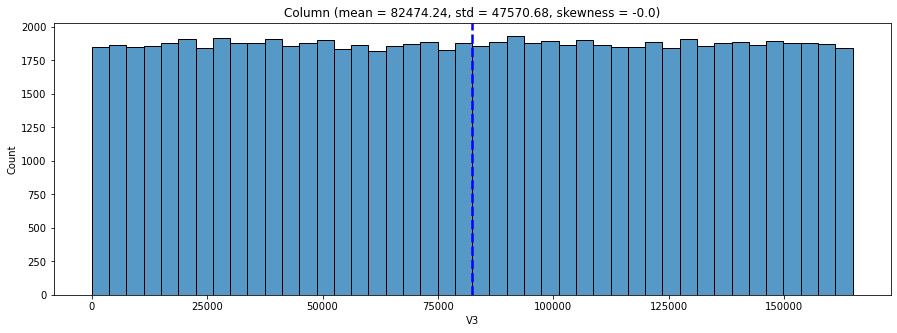

In [13]:
plot_hist(X_train.V3)

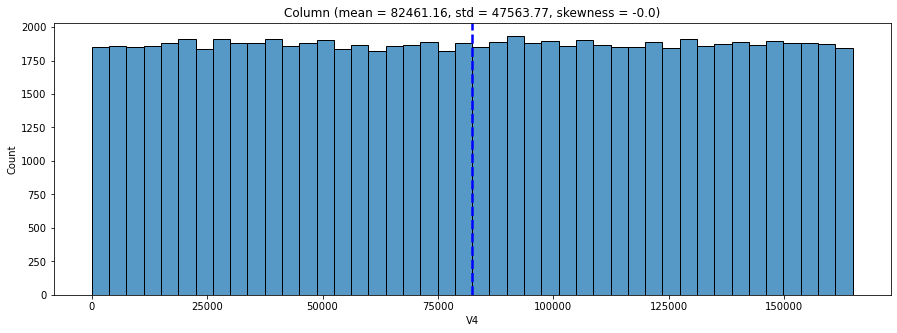

In [14]:
plot_hist(X_train.V4)

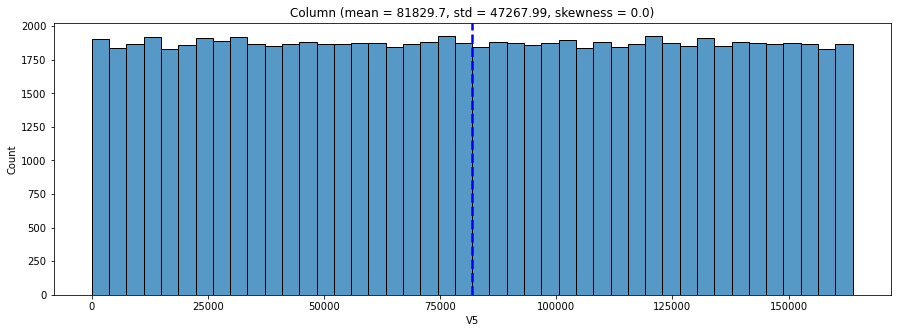

In [15]:
plot_hist(X_train.V5)

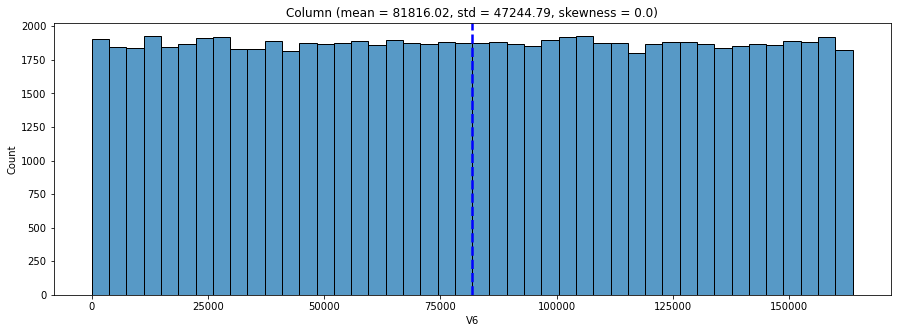

In [16]:
plot_hist(X_train.V6)

### Undersampling

In [17]:
counts_ls = list(y_train.value_counts())
counts_ls

[27168, 16359, 13621, 9275, 5884, 3045, 2665, 1497, 1360, 852, 704]

In [18]:
counts_ls_prob = [elem / sum(counts_ls) for elem in counts_ls]

In [19]:
class_ls = list(y_train.value_counts().index)

In [20]:
dict_class = {class_ls[i]: counts_ls_prob[i] for i in range(len(counts_ls_prob))}
dict_class

{'4': 0.3295887419628776,
 '3': 0.19845929879898094,
 '7': 0.1652432366856727,
 '10': 0.11251971369646974,
 '9': 0.0713817784787092,
 '5': 0.03694043430789761,
 '6': 0.0323304622103603,
 '1': 0.01816086376319301,
 '2': 0.016498847506975615,
 '8': 0.01033604270289943,
 '11': 0.008540579885963849}

#### First version (difference)

In [21]:
def exp_dist(x, l):
    return l * np.exp(-l * x)

In [22]:
x_pts = np.linspace(0, 10, 11)

In [23]:
y_pts = exp_dist(x_pts, 0.32)

In [24]:
factors_diff = [(1 - y ** 0.5) for y in y_pts]

In [25]:
y_factor = [y_pts[i] * factors_diff[i] for i in range(len(y_pts))]

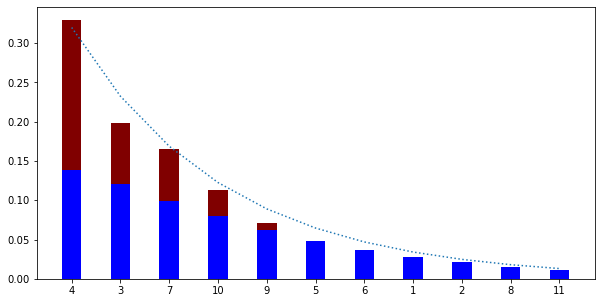

In [26]:
fig = plt.figure(figsize = (10, 5))
ypoints = np.array([3, 8, 1, 10000])
plt.plot(y_pts, linestyle = 'dotted')
plt.bar(class_ls, counts_ls_prob, color ='maroon',
        width = 0.4)
plt.bar(class_ls, y_factor, color ='blue',
        width = 0.4)
plt.show()

In [27]:
dict_class_factors_diff = {class_ls[i]: int(factors_diff[i] * counts_ls[i]) for i in range(len(counts_ls))}
dict_class_factors_diff

{'4': 11799,
 '3': 8473,
 '7': 8025,
 '10': 6028,
 '9': 4128,
 '5': 2271,
 '6': 2087,
 '1': 1220,
 '2': 1146,
 '8': 737,
 '11': 623}

#### Second version

In [28]:
log_transform = np.log(counts_ls)

In [29]:
log_transform

array([10.20979509,  9.70253348,  9.519368  ,  9.13507789,  8.67999208,
        8.02125618,  7.88795934,  7.31121838,  7.21523998,  6.74758653,
        6.55677836])

In [30]:
factors_log = [elem / np.sum(log_transform) for elem in log_transform]

In [31]:
factors_log

[0.11221182076989097,
 0.10663670903993894,
 0.10462360961814479,
 0.10040002896058695,
 0.09539836081499542,
 0.0881584549914865,
 0.08669344209099158,
 0.0803547103346867,
 0.07929984962856931,
 0.07416005545355417,
 0.07206295829715474]

In [32]:
min_factors_log = min(factors_log)
min_factors_log

0.07206295829715474

In [33]:
min_counts_ls = min(counts_ls)
min_counts_ls

704

In [34]:
dict_class_factors_log = {class_ls[i]: int(min_counts_ls * factors_log[i] / min_factors_log) for i in range(len(counts_ls))}
dict_class_factors_log

{'4': 1096,
 '3': 1041,
 '7': 1022,
 '10': 980,
 '9': 931,
 '5': 861,
 '6': 846,
 '1': 785,
 '2': 774,
 '8': 724,
 '11': 704}

In [35]:
from imblearn.under_sampling import RandomUnderSampler

In [36]:
undersample = RandomUnderSampler(sampling_strategy=dict_class_factors_diff)

In [37]:
X_train_und, y_train_und = undersample.fit_resample(X_train, y_train)

In [38]:
X_train_und

,V1,V2,V3,V4,V5,V6,V7
0,2,1,100771.0,100755.0,85440.0,53590.0,106704.0
1,5,2,38675.0,38667.0,88651.0,12525.0,42315.0
2,5,2,30019.0,30015.0,122387.0,60282.0,3730.0
3,3,3,154610.0,154586.0,139524.0,39150.0,143536.0
4,2,1,94768.0,94753.0,72859.0,59888.0,88129.0
...,...,...,...,...,...,...,...
46532,3,3,156222.0,156198.0,112469.0,49884.0,91514.0
46533,1,3,115353.0,115335.0,127087.0,26900.0,115461.0
46534,3,2,156390.0,156366.0,142260.0,31039.0,86380.0
46535,4,4,49002.0,48994.0,135858.0,12496.0,100000.0


In [39]:
y_train_und

0        1
1        1
2        1
3        1
4        1
        ..
46532    9
46533    9
46534    9
46535    9
46536    9
Name: Class, Length: 46537, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

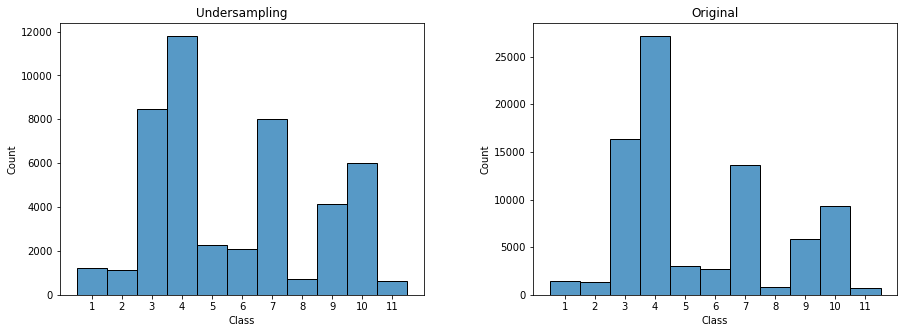

In [40]:
__fig__, __axs__ = plt.subplots(ncols=2, figsize=(15, 5))
__fig__.subplots_adjust(hspace=0.1, wspace=0.3)

__axs__[0].set(title="Undersampling")
_ = sns.histplot(x=y_train_und, ax=__axs__[0])
__axs__[1].set(title="Original")
_ = sns.histplot(x=y_train, ax=__axs__[1])

### Kmeans para agrupar clases

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [42]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_train)
    distortions.append(kmeanModel.inertia_)

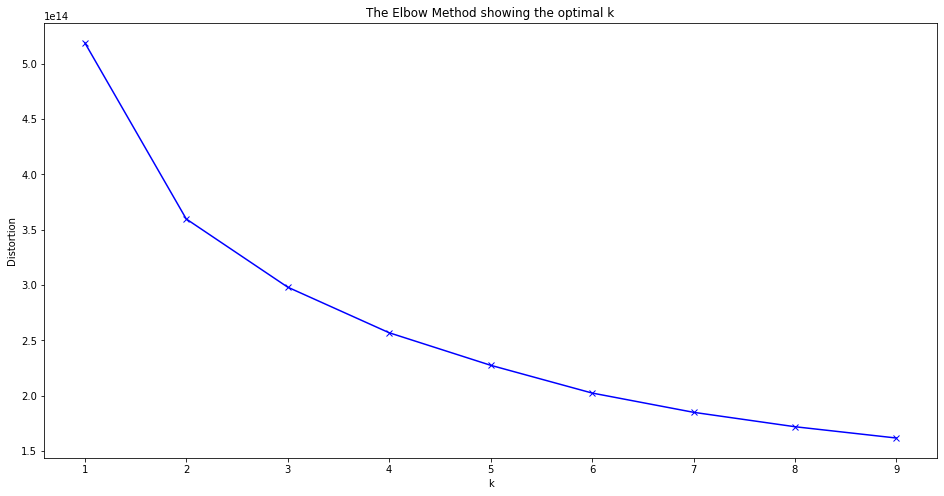

In [43]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [44]:
k_opt = 2

In [45]:
km = KMeans(
    n_clusters=k_opt, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)

In [46]:
y_km_train = km.fit_predict(X_train)

In [47]:
indexes_train = X_train.index.values
indexes_train

array([    0,     1,     2, ..., 46534, 46535, 46536], dtype=int64)

In [48]:
y_km_train_df = pd.DataFrame(y_km_train, columns = ['cluster']).set_index(indexes_train, drop=True, append=False, inplace=False, verify_integrity=False)
y_km_train_df

,cluster
0,1
1,0
2,0
3,1
4,1
...,...
46532,1
46533,1
46534,1
46535,0


In [49]:
X_train = pd.concat((X_train, y_km_train_df), axis = 1)
X_train

,V1,V2,V3,V4,V5,V6,V7,cluster
0,2,1,100771.0,100755.0,85440.0,53590.0,106704.0,1
1,5,2,38675.0,38667.0,88651.0,12525.0,42315.0,0
2,5,2,30019.0,30015.0,122387.0,60282.0,3730.0,0
3,3,3,154610.0,154586.0,139524.0,39150.0,143536.0,1
4,2,1,94768.0,94753.0,72859.0,59888.0,88129.0,1
...,...,...,...,...,...,...,...,...
46532,3,3,156222.0,156198.0,112469.0,49884.0,91514.0,1
46533,1,3,115353.0,115335.0,127087.0,26900.0,115461.0,1
46534,3,2,156390.0,156366.0,142260.0,31039.0,86380.0,1
46535,4,4,49002.0,48994.0,135858.0,12496.0,100000.0,0


In [50]:
y_km_test = km.fit_predict(X_test)

In [51]:
indexes_test = X_test.index.values
indexes_test

array([  9783,  85013,  70883, ..., 114945,  19389, 155502], dtype=int64)

In [52]:
y_km_test_df = pd.DataFrame(y_km_test, columns = ['cluster']).set_index(indexes_test, drop=True, append=False, inplace=False, verify_integrity=False)
y_km_test_df

,cluster
9783,0
85013,0
70883,0
64466,0
82448,0
...,...
102897,1
40732,0
114945,1
19389,0


In [53]:
X_test = pd.concat((X_test, y_km_test_df), axis = 1)
X_test

,V1,V2,V3,V4,V5,V6,V7,cluster
9783,1,4,115577.0,115559.0,90402.0,18088.0,121817.0,0
85013,3,4,160657.0,160632.0,5651.0,148068.0,64938.0,0
70883,3,1,146527.0,146506.0,27276.0,100859.0,115620.0,0
64466,3,2,140110.0,140090.0,17717.0,63955.0,11320.0,0
82448,3,4,158092.0,158068.0,399.0,161841.0,163997.0,0
...,...,...,...,...,...,...,...,...
102897,4,1,57373.0,57362.0,64919.0,55294.0,68753.0,1
40732,2,2,88903.0,88889.0,34335.0,31755.0,72117.0,0
114945,4,3,69421.0,69407.0,23650.0,37747.0,133916.0,1
19389,1,2,125183.0,125165.0,123080.0,18023.0,89884.0,0


### Preprocesamiento

In [54]:
import copy

In [55]:
X_train_pp = copy.deepcopy(X_train)
#X_train_pp = X_train_pp.drop(columns = ['cluster'])
X_train_pp

,V1,V2,V3,V4,V5,V6,V7,cluster
0,2,1,100771.0,100755.0,85440.0,53590.0,106704.0,1
1,5,2,38675.0,38667.0,88651.0,12525.0,42315.0,0
2,5,2,30019.0,30015.0,122387.0,60282.0,3730.0,0
3,3,3,154610.0,154586.0,139524.0,39150.0,143536.0,1
4,2,1,94768.0,94753.0,72859.0,59888.0,88129.0,1
...,...,...,...,...,...,...,...,...
46532,3,3,156222.0,156198.0,112469.0,49884.0,91514.0,1
46533,1,3,115353.0,115335.0,127087.0,26900.0,115461.0,1
46534,3,2,156390.0,156366.0,142260.0,31039.0,86380.0,1
46535,4,4,49002.0,48994.0,135858.0,12496.0,100000.0,0


In [56]:
X_test_pp = copy.deepcopy(X_test)
#X_test_pp = X_test_pp.drop(columns = ['cluster'])
X_test_pp

,V1,V2,V3,V4,V5,V6,V7,cluster
9783,1,4,115577.0,115559.0,90402.0,18088.0,121817.0,0
85013,3,4,160657.0,160632.0,5651.0,148068.0,64938.0,0
70883,3,1,146527.0,146506.0,27276.0,100859.0,115620.0,0
64466,3,2,140110.0,140090.0,17717.0,63955.0,11320.0,0
82448,3,4,158092.0,158068.0,399.0,161841.0,163997.0,0
...,...,...,...,...,...,...,...,...
102897,4,1,57373.0,57362.0,64919.0,55294.0,68753.0,1
40732,2,2,88903.0,88889.0,34335.0,31755.0,72117.0,0
114945,4,3,69421.0,69407.0,23650.0,37747.0,133916.0,1
19389,1,2,125183.0,125165.0,123080.0,18023.0,89884.0,0


In [57]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale_features(X_train, X_test, to_scale):
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    scaler.fit(X_train[to_scale])
    train_scaled = scaler.transform(X_train[to_scale])
    test_scaled = scaler.transform(X_test[to_scale])
    
    return train_scaled, test_scaled

In [58]:
from sklearn.preprocessing import OneHotEncoder

def ohe_features(X, to_encode):
    ohe = OneHotEncoder(sparse = False)
    encoded = ohe.fit_transform(X[to_encode])
    
    return encoded

In [59]:
def ohe(df, columns):
    for col in columns:
        #print(col)
        col_encoded = pd.get_dummies(pd.Series(df[col]))
        #print(col_encoded.head(3))
        df[['{}_'.format(col) + str(c) for c in list(col_encoded.columns.values)]] = col_encoded
        df = df.drop(columns = col)
        
    return df

#### Aplicamos OneHotEncoding

In [60]:
cols_to_encode = ['V1', 'V2', 'cluster']

In [61]:
#X_train_ohe = ohe_features(copy.deepcopy(X_train_pp), cols_to_encode)

In [62]:
X_train_ohe = ohe(copy.deepcopy(X_train_pp), cols_to_encode)

In [63]:
X_train_ohe

,V3,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,cluster_0,cluster_1
0,100771.0,100755.0,85440.0,53590.0,106704.0,0,1,0,0,0,1,0,0,0,0,1
1,38675.0,38667.0,88651.0,12525.0,42315.0,0,0,0,0,1,0,1,0,0,1,0
2,30019.0,30015.0,122387.0,60282.0,3730.0,0,0,0,0,1,0,1,0,0,1,0
3,154610.0,154586.0,139524.0,39150.0,143536.0,0,0,1,0,0,0,0,1,0,0,1
4,94768.0,94753.0,72859.0,59888.0,88129.0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46532,156222.0,156198.0,112469.0,49884.0,91514.0,0,0,1,0,0,0,0,1,0,0,1
46533,115353.0,115335.0,127087.0,26900.0,115461.0,1,0,0,0,0,0,0,1,0,0,1
46534,156390.0,156366.0,142260.0,31039.0,86380.0,0,0,1,0,0,0,1,0,0,0,1
46535,49002.0,48994.0,135858.0,12496.0,100000.0,0,0,0,1,0,0,0,0,1,1,0


In [64]:
#X_test_ohe = ohe_features(copy.deepcopy(X_test_pp), cols_to_encode)

In [65]:
X_test_ohe = ohe(copy.deepcopy(X_test_pp), cols_to_encode)

In [66]:
X_test_ohe

,V3,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,cluster_0,cluster_1
9783,115577.0,115559.0,90402.0,18088.0,121817.0,1,0,0,0,0,0,0,0,1,1,0
85013,160657.0,160632.0,5651.0,148068.0,64938.0,0,0,1,0,0,0,0,0,1,1,0
70883,146527.0,146506.0,27276.0,100859.0,115620.0,0,0,1,0,0,1,0,0,0,1,0
64466,140110.0,140090.0,17717.0,63955.0,11320.0,0,0,1,0,0,0,1,0,0,1,0
82448,158092.0,158068.0,399.0,161841.0,163997.0,0,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102897,57373.0,57362.0,64919.0,55294.0,68753.0,0,0,0,1,0,1,0,0,0,0,1
40732,88903.0,88889.0,34335.0,31755.0,72117.0,0,1,0,0,0,0,1,0,0,1,0
114945,69421.0,69407.0,23650.0,37747.0,133916.0,0,0,0,1,0,0,0,1,0,0,1
19389,125183.0,125165.0,123080.0,18023.0,89884.0,1,0,0,0,0,0,1,0,0,1,0


In [67]:
begin = 0
end = k_opt

In [68]:
list(X_test_ohe.columns.values)[begin:-end]

['V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V1_1',
 'V1_2',
 'V1_3',
 'V1_4',
 'V1_5',
 'V2_1',
 'V2_2',
 'V2_3',
 'V2_4']

In [69]:
cols_to_scale = list(X_test_ohe.columns.values)[begin:]

In [70]:
X_train_model, X_test_model = scale_features(copy.deepcopy(X_train_ohe), copy.deepcopy(X_test_ohe), cols_to_scale)

In [71]:
#X_train_model = np.concatenate([X_train_scaled, X_train_ohe], axis=1)
#X_train_model

In [72]:
y_train_model = copy.deepcopy(y_train_und)
#y_train_model = copy.deepcopy(y_km_train)
y_train_model

0        1
1        1
2        1
3        1
4        1
        ..
46532    9
46533    9
46534    9
46535    9
46536    9
Name: Class, Length: 46537, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

In [73]:
#X_test_model = np.concatenate([X_test_scaled, X_test_ohe], axis=1)
#X_test_model

In [74]:
y_test_model = copy.deepcopy(y_test)
#y_test_model = copy.deepcopy(y_km_test)
y_test_model

9783       9
85013      4
70883      7
64466      7
82448      4
          ..
102897    10
40732      7
114945    10
19389      4
155502     4
Name: Class, Length: 82430, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

### Modelado

In [75]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#### Balanceo de clases

In [76]:
#!pip install imblearn

In [77]:
#from imblearn.over_sampling import SMOTE # Library to Balance Dataset
#smote = SMOTE()
#X_train_model, y_train_model = smote.fit_resample(X_train_model, y_train) # Balancing our Data
#X_train_model, y_train_model # Checking our new shape after Over_Sampling

In [78]:
accuracy = {}

def train_model(model, model_name, x_tr, y_tr, x_ts, y_ts):
    print(model_name)
    
    # Fitting model
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model, x_tr, y_tr, cv=kfold, scoring='accuracy')
    print(cv_results)
    msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
    print(msg)
    
    retrained_model = model.fit(x_tr, y_tr)
    
    # Predicting
    pred = retrained_model.predict(x_ts)
    y_test_aux = np.array(y_ts)
    values = np.array([[pred[i], y_test_aux[i]] for i in range(len(y_test_aux))])
    #print(pd.DataFrame(values, columns = ['pred', 'real']))
    
    #Model accuracy
    acc = accuracy_score(y_ts, pred) * 100
    accuracy[model_name] = acc
    print('accuracy_score', acc, '\n')
    
    # Classification Report
    print('Classification Report')
    print(classification_report(y_ts, pred))

### Logistic Regression

In [79]:
model = linear_model.LogisticRegression(penalty = 'l2', max_iter = 1000, verbose = True)
model_name='Logistic Regression'
train_model(model, model_name, X_train_model, y_train_model, X_test_model, y_test_model)

Logistic Regression


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.01063601 0.07928664 0.         0.11314065 0.02482003]
Logistic Regression: 0.045577 (0.043429)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s finished


accuracy_score 34.00339682154556 

Classification Report


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1476
          10       0.00      0.00      0.00      9086
          11       0.00      0.00      0.00       677
           2       0.00      0.00      0.00      1488
           3       0.30      0.27      0.28     16351
           4       0.38      0.58      0.46     27312
           5       0.14      0.02      0.03      3123
           6       0.19      0.20      0.19      2545
           7       0.34      0.39      0.37     13623
           8       0.00      0.00      0.00       854
           9       0.25      0.33      0.29      5895

    accuracy                           0.34     82430
   macro avg       0.15      0.16      0.15     82430
weighted avg       0.27      0.34      0.30     82430



C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
model = linear_model.LogisticRegression(penalty = 'l2', max_iter = 1000, verbose = True)
model_name='Logistic Regression'
retrained_model = model.fit(X_train_model, y_train_model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s finished


In [81]:
# Predicting
pred = retrained_model.predict(X_train_model)
y_train_aux = np.array(y_train_model)
values = np.array([[pred[i], y_train_aux[i]] for i in range(len(y_train_aux))])
results_train = pd.DataFrame(values, columns = ['pred', 'real'])
print(results_train)

      pred real
0        7    1
1        7    1
2        4    1
3        9    1
4        7    1
...    ...  ...
46532    4    9
46533    7    9
46534    9    9
46535    9    9
46536    7    9

[46537 rows x 2 columns]


In [82]:
#Model accuracy
acc = accuracy_score(results_train.real, results_train.pred) * 100
accuracy[model_name] = acc
print('accuracy_score', acc, '\n')

accuracy_score 32.88136321636547 



In [83]:
# Classification Report
print('Classification Report')
print(classification_report(results_train.real, results_train.pred))

Classification Report


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1220
          10       0.00      0.00      0.00      6028
          11       0.00      0.00      0.00       623
           2       0.00      0.00      0.00      1146
           3       0.33      0.35      0.34      8473
           4       0.30      0.58      0.40     11799
           5       0.08      0.01      0.01      2271
           6       0.38      0.31      0.34      2087
           7       0.40      0.44      0.42      8025
           8       0.00      0.00      0.00       737
           9       0.32      0.31      0.31      4128

    accuracy                           0.33     46537
   macro avg       0.17      0.18      0.17     46537
weighted avg       0.26      0.33      0.28     46537



C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
# Predicting
pred = retrained_model.predict(X_test_model)
y_test_aux = np.array(y_test_model)
values = np.array([[pred[i], y_test_aux[i]] for i in range(len(y_test_aux))])
results_test = pd.DataFrame(values, columns = ['pred', 'real'])
print(results_test)

      pred real
0        7    9
1        4    4
2        3    7
3        3    7
4        3    4
...    ...  ...
82425    7   10
82426    3    7
82427    7   10
82428    9    4
82429    4    4

[82430 rows x 2 columns]


In [85]:
#Model accuracy
acc = accuracy_score(results_test.real, results_test.pred) * 100
accuracy[model_name] = acc
print('accuracy_score', acc, '\n')

accuracy_score 34.00339682154556 



In [86]:
# Classification Report
print('Classification Report')
print(classification_report(results_test.real, results_test.pred))

Classification Report


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1476
          10       0.00      0.00      0.00      9086
          11       0.00      0.00      0.00       677
           2       0.00      0.00      0.00      1488
           3       0.30      0.27      0.28     16351
           4       0.38      0.58      0.46     27312
           5       0.14      0.02      0.03      3123
           6       0.19      0.20      0.19      2545
           7       0.34      0.39      0.37     13623
           8       0.00      0.00      0.00       854
           9       0.25      0.33      0.29      5895

    accuracy                           0.34     82430
   macro avg       0.15      0.16      0.15     82430
weighted avg       0.27      0.34      0.30     82430



C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SGD Classifier

In [87]:
model = linear_model.SGDClassifier(loss='log', penalty='l2', max_iter=1000, tol=1e-5)
model_name='SGD Classifier'
train_model(model, model_name, X_train_model, y_train_model, X_test_model, y_test_model)

SGD Classifier
[0.0090245  0.08358401 0.         0.10787579 0.03911035]
SGD Classifier: 0.047919 (0.041841)
accuracy_score 35.94079825306321 

Classification Report


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1476
          10       0.00      0.00      0.00      9086
          11       0.00      0.00      0.00       677
           2       0.00      0.00      0.00      1488
           3       0.35      0.27      0.31     16351
           4       0.38      0.67      0.49     27312
           5       0.00      0.00      0.00      3123
           6       0.23      0.17      0.19      2545
           7       0.37      0.32      0.35     13623
           8       0.00      0.00      0.00       854
           9       0.26      0.35      0.29      5895

    accuracy                           0.36     82430
   macro avg       0.14      0.16      0.15     82430
weighted avg       0.28      0.36      0.31     82430



C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


https://www.aprendemachinelearning.com/regresion-logistica-con-python-paso-a-paso/

## Asignación 2 &#x1F921;

Evalue su modelo final en el conjunto de test (X_test y y_test). Su práctica será evaluada acorde a las técnicas aplicadas, la estimación de $E_{out}$, el valor de $E_{test}$, y contra las métricas obtenidas por sus compañeros.